# Code to extract and plot CMIP6 Trajectories used in the manuscript "" for temperature forcing

### Data sourced from Copernicus Climate Change Service

In [49]:
import sys
import zipfile, os, glob
import os, glob, re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## SST Projections SSP1-2.6

In [50]:
zip_path = "ssp_1_2.6.zip"
extract_dir = "sst_extracted_ssp126"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

sorted(os.listdir(extract_dir))[:20]

['provenance.json',
 'provenance.png',
 'tos_Omon_CESM2_ssp126_r4i1p1f1_gn_20150115-21001215.nc']

In [51]:
nc_files = sorted(glob.glob(os.path.join(extract_dir, "**", "*.nc"), recursive=True))
print("Found files:", len(nc_files))
print("First file:", os.path.basename(nc_files[0]))
print("Last file :", os.path.basename(nc_files[-1]))

Found files: 1
First file: tos_Omon_CESM2_ssp126_r4i1p1f1_gn_20150115-21001215.nc
Last file : tos_Omon_CESM2_ssp126_r4i1p1f1_gn_20150115-21001215.nc


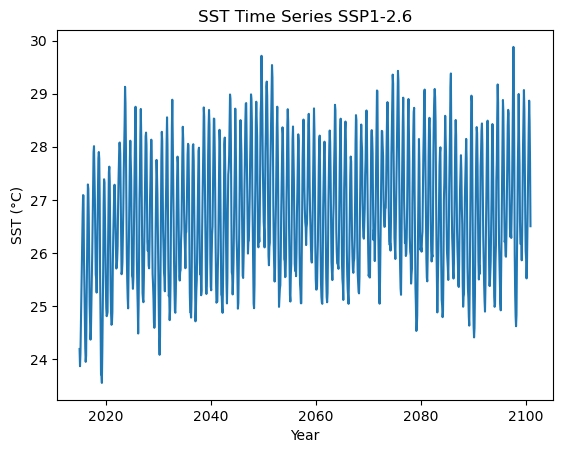

In [52]:
def preprocess(ds):
    for v in ["nlat", "nlon"]:
        if v in ds.coords or v in ds.variables:
            ds = ds.drop_vars(v, errors="ignore")
    return ds

ds = xr.open_mfdataset(
    nc_files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    coords="minimal",
    data_vars="minimal",
    compat="override",
    join="override",
    parallel=False,
)

# Pick SST variable 'tos'
sst_var = "tos" if "tos" in ds.data_vars else list(ds.data_vars)[0]
tos = ds[sst_var]

# Reduce to a 1D time series by averaging all other dims
dims_to_mean = [d for d in tos.dims if d != "time"]
ts = tos.mean(dim=dims_to_mean, skipna=True)

# Build a monthly time index from cftime objects
tvals = ts["time"].values
year = np.array([t.year for t in tvals], dtype=int)
month = np.array([t.month for t in tvals], dtype=int)
decimal_year = year + (month - 1) / 12.0

# Convert to a pandas series
series = pd.Series(ts.values, index=decimal_year).sort_index()

plt.figure()
plt.plot(series.index, series.values)
plt.title(f"SST Time Series SSP1-2.6")
plt.xlabel("Year")
plt.ylabel("SST (°C)")
plt.show()

### converting output to .csv

In [53]:
out = pd.DataFrame({"decimal_year": series.index, "sst": series.values})
out.to_csv("sst_timeseries_ssp126.csv", index=False)

## SST Projections SSP 2-4.5

In [54]:
zip_path = "ssp_2_4.5.zip"
extract_dir = "sst_extracted_ssp245"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted to:", extract_dir)

Extracted to: sst_extracted_ssp245


In [55]:
nc_files = sorted(glob.glob(os.path.join(extract_dir, "**", "*.nc"), recursive=True))

if not nc_files:
    raise FileNotFoundError(f"No .nc files found under {extract_dir!r}")

print("Found files:", len(nc_files))
print("First file:", os.path.basename(nc_files[0]))
print("Last file :", os.path.basename(nc_files[-1]))

# Ensure filenames are time-sorted
def extract_yyyymm(path):
    name = Path(path).name
    m = re.search(r"(\d{6})-\d{6}", name)
    return int(m.group(1)) if m else 0

nc_files = sorted(nc_files, key=extract_yyyymm)

# Confirm scenario tag in filenames 
for f in nc_files[:10]:
    print(Path(f).name)

Found files: 1
First file: tos_Omon_CESM2_ssp245_r4i1p1f1_gn_20150115-21001215.nc
Last file : tos_Omon_CESM2_ssp245_r4i1p1f1_gn_20150115-21001215.nc
tos_Omon_CESM2_ssp245_r4i1p1f1_gn_20150115-21001215.nc


In [56]:
def preprocess(ds):
    for v in ["nlat", "nlon"]:
        if v in ds.coords or v in ds.variables:
            ds = ds.drop_vars(v, errors="ignore")
    return ds

ds = xr.open_mfdataset(
    nc_files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    coords="minimal",
    data_vars="minimal",
    compat="override",
    join="override",
    parallel=False,
)

ds

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1032, nlat: 12, nlon: 8, d2: 2, vertices: 4)
Coordinates:
  * time       (time) object 8kB 2015-01-15 13:00:00.000007 ... 2100-12-15 12...
    lat        (nlat, nlon) float64 768B dask.array<chunksize=(12, 8), meta=np.ndarray>
    lon        (nlat, nlon) float64 768B dask.array<chunksize=(12, 8), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, d2, vertices
Data variables:
    tos        (time, nlat, nlon) float32 396kB dask.array<chunksize=(1032, 12, 8), meta=np.ndarray>
    time_bnds  (time, d2) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lat_bnds   (time, nlat, nlon, vertices) float32 2MB dask.array<chunksize=(1032, 12, 8, 4), meta=np.ndarray>
    lon_bnds   (time, nlat, nlon, vertices) float32 2MB dask.array<chunksize=(1032, 12, 8, 4), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1732
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/d568c0e9-912a-489a-a579-0335dc0b4041
    variable_id:            tos
    variant_info:           CMIP6 SSP2-4.5 experiments (2015-2100) with CAM6,...
    variant_label:          r4i1p1f1

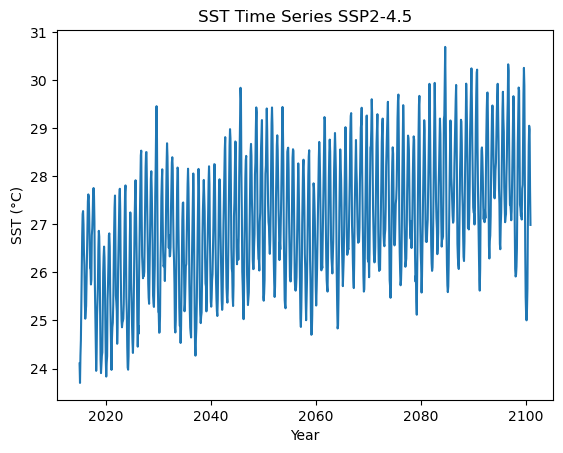

In [57]:
# Pick variable 'tos'
sst_var = "tos" if "tos" in ds.data_vars else list(ds.data_vars)[0]
tos = ds[sst_var]

# Mean over all non-time dims 
dims_to_mean = [d for d in tos.dims if d != "time"]
ts = tos.mean(dim=dims_to_mean, skipna=True)

# Time axis from cftime objects
tvals = ts["time"].values
year = np.array([t.year for t in tvals], dtype=int)
month = np.array([t.month for t in tvals], dtype=int)
decimal_year = year + (month - 1) / 12.0

series = pd.Series(ts.values, index=decimal_year).sort_index()

plt.figure()
plt.plot(series.index, series.values)
plt.title("SST Time Series SSP2-4.5")
plt.xlabel("Year")
plt.ylabel("SST (°C)")
plt.show()

### converting output to .csv

In [58]:
out = pd.DataFrame({"decimal_year": series.index, "sst": series.values})
out.to_csv("sst_timeseries_ssp245.csv", index=False)

## SST Projections SSP 3-7.0

In [59]:
zip_path = "ssp_3_7.0.zip"
extract_dir = "sst_extracted_ssp370"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted to:", extract_dir)

Extracted to: sst_extracted_ssp370


In [60]:
nc_files = sorted(glob.glob(os.path.join(extract_dir, "**", "*.nc"), recursive=True))
if not nc_files:
    raise FileNotFoundError(f"No .nc files found under {extract_dir!r}")

# Sort files by starting YYYYMM 
def extract_yyyymm(path):
    name = Path(path).name
    m = re.search(r"(\d{6})-\d{6}", name)
    return int(m.group(1)) if m else 0

nc_files = sorted(nc_files, key=extract_yyyymm)

print("Found files:", len(nc_files))
print("First file:", Path(nc_files[0]).name)
print("Last file :", Path(nc_files[-1]).name)

# Confirm scenario tag in filenames 
bad = [Path(f).name for f in nc_files if "ssp370" in Path(f).name.lower() or "ssp" not in Path(f).name.lower()]
print("Example files:")
for f in nc_files[:10]:
    print("  ", Path(f).name)

Found files: 1
First file: tos_Omon_CESM2_ssp370_r4i1p1f1_gn_20150115-21001215.nc
Last file : tos_Omon_CESM2_ssp370_r4i1p1f1_gn_20150115-21001215.nc
Example files:
   tos_Omon_CESM2_ssp370_r4i1p1f1_gn_20150115-21001215.nc


In [61]:
def preprocess(ds):
    for v in ["nlat", "nlon"]:
        if v in ds.coords or v in ds.variables:
            ds = ds.drop_vars(v, errors="ignore")
    return ds

ds = xr.open_mfdataset(
    nc_files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    coords="minimal",
    data_vars="minimal",
    compat="override",
    join="override",
    parallel=False,
)

ds

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1032, nlat: 12, nlon: 8, d2: 2, vertices: 4)
Coordinates:
  * time       (time) object 8kB 2015-01-15 13:00:00.000007 ... 2100-12-15 12...
    lat        (nlat, nlon) float64 768B dask.array<chunksize=(12, 8), meta=np.ndarray>
    lon        (nlat, nlon) float64 768B dask.array<chunksize=(12, 8), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, d2, vertices
Data variables:
    tos        (time, nlat, nlon) float32 396kB dask.array<chunksize=(1032, 12, 8), meta=np.ndarray>
    time_bnds  (time, d2) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lat_bnds   (time, nlat, nlon, vertices) float32 2MB dask.array<chunksize=(1032, 12, 8, 4), meta=np.ndarray>
    lon_bnds   (time, nlat, nlon, vertices) float32 2MB dask.array<chunksize=(1032, 12, 8, 4), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1738
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/a9b3fa42-10a0-46a5-a65c-452fe5a163c7
    variable_id:            tos
    variant_info:           CMIP6 SSP3-7.0 experiments (2015-2100) with CAM6,...
    variant_label:          r4i1p1f1

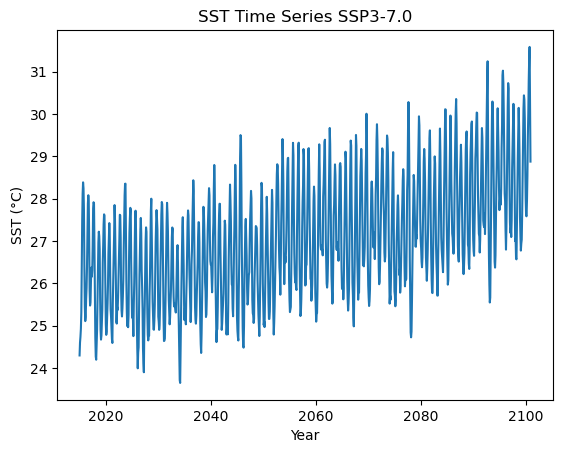

In [62]:
sst_var = "tos" if "tos" in ds.data_vars else list(ds.data_vars)[0]
tos = ds[sst_var]

dims_to_mean = [d for d in tos.dims if d != "time"]
ts = tos.mean(dim=dims_to_mean, skipna=True)

# Time axis from cftime objects
tvals = ts["time"].values
year = np.array([t.year for t in tvals], dtype=int)
month = np.array([t.month for t in tvals], dtype=int)
decimal_year = year + (month - 1) / 12.0

series = pd.Series(ts.values, index=decimal_year).sort_index()

plt.figure()
plt.plot(series.index, series.values)
plt.title("SST Time Series SSP3-7.0")
plt.xlabel("Year")
plt.ylabel("SST (°C)")
plt.show()

### converting output to .csv

In [63]:
out = pd.DataFrame({"decimal_year": series.index, "sst": series.values})
out.to_csv("sst_timeseries_ssp370.csv", index=False)

# Combining all Scenarios into one plot

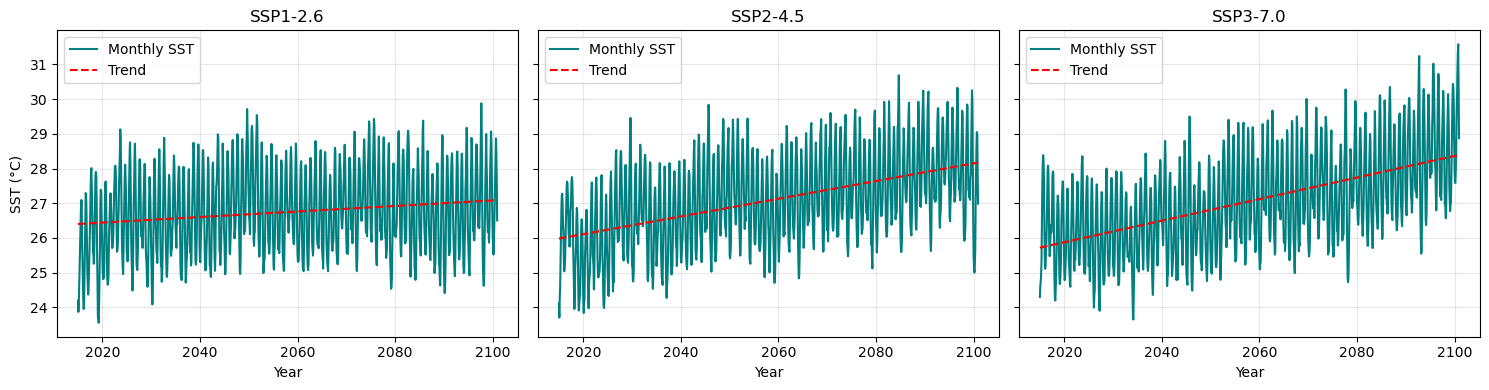

In [64]:
files = {
    "SSP1-2.6": "sst_timeseries_ssp126.csv",
    "SSP2-4.5": "sst_timeseries_ssp245.csv",
    "SSP3-7.0": "sst_timeseries_ssp370.csv",
}

series = {}
for label, path in files.items():
    df = pd.read_csv(path)
    df = df.dropna(subset=["decimal_year", "sst"]).sort_values("decimal_year")
    series[label] = df

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, (label, df) in zip(axes, series.items()):
    x = df["decimal_year"].values
    y = df["sst"].values
    
    # ---- plot raw series ----
    ax.plot(x, y, label="Monthly SST", color="teal")
    
    # ---- compute linear trend ----
    coeffs = np.polyfit(x, y, 1)     # slope, intercept
    trend = np.polyval(coeffs, x)
    
    # ---- plot trend ----
    ax.plot(x, trend, linestyle="--", label="Trend", color="red")
    
    ax.set_title(label)
    ax.set_xlabel("Year")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

axes[0].set_ylabel("SST (°C)")
plt.tight_layout()

plt.savefig("figures/SSPS.pdf",
            format='pdf',
            dpi=300,
            bbox_inches='tight')

plt.show()